In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
# Config the matplotlib backend as plotting inline in IPython
%config InlineBackend.figure_format = 'retina'

/Users/lkuligin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#pickle_file = 'notMNIST.pickle'
pickle_file = 'notMNIST_clean.pickle'
data = {}
try:
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
        train_dataset = data['train_dataset']
        train_labels = data['train_labels']
        valid_dataset = data['valid_dataset']
        valid_labels = data['valid_labels']
        test_dataset = data['test_dataset']
        test_labels = data['test_labels']
    del data
except Exception as e:
    print('Unable to load data from', pickle_file, ':', e)

In [3]:
IMAGE_SIZE = 28
NUM_LABELS = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, IMAGE_SIZE **2 )).astype(np.float32)
    labels = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (185307, 784) (185307, 10)
Validation set (8856, 784) (8856, 10)
Test set (8609, 784) (8609, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Problem 1

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.

In [16]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, IMAGE_SIZE **2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights = tf.Variable(
    tf.truncated_normal([IMAGE_SIZE **2, NUM_LABELS]))
    biases = tf.Variable(tf.zeros([NUM_LABELS]))
    tf_beta = tf.placeholder(tf.float32)
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) 
        + tf_beta*tf.nn.l2_loss(weights))
  
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [59]:
num_steps = 3001
accuracy_obs = {}

#for beta in np.arange(0., 1.0, 0.05):
for beta in np.arange(0., 10.**-2, 5*10.**-4):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)   
        accuracy_obs[beta] = accuracy(test_prediction.eval(), test_labels)

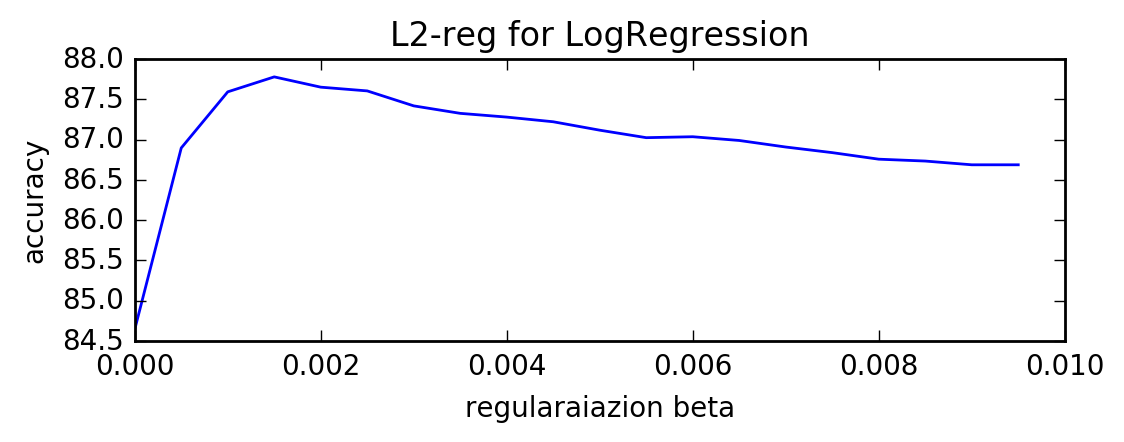

In [58]:
x = sorted([key for key in accuracy_obs.keys()])
plt.figure(1)
plt.subplot(211)
plt.plot(x, [accuracy_obs[x_] for x_ in x])
plt.title("L2-reg for LogRegression")
plt.xlabel("regularaiazion beta")
plt.ylabel("accuracy");

In [61]:
BATCH_SIZE = 128
HIDDEN_NODES = 1024

graph = tf.Graph()
def calculate_layer1(prev_layer, weights, biases):
    return tf.nn.relu(tf.matmul(prev_layer, weights) + biases)

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(BATCH_SIZE, IMAGE_SIZE**2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
    
    weights0 = tf.Variable(tf.truncated_normal([IMAGE_SIZE **2, HIDDEN_NODES]))
    biases0 = tf.Variable(tf.zeros([HIDDEN_NODES]))
    weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS]))
    biases = tf.Variable(tf.zeros([NUM_LABELS]))
    
    tf_train_layer1 = calculate_layer1(tf_train_dataset, weights0, biases0) 
    logits = tf.matmul(tf_train_layer1, weights) + biases
    loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + 
            tf_beta * (tf.nn.l2_loss(weights0)+tf.nn.l2_loss(weights)))
  
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    tf_valid_layer1 = calculate_layer1(tf_valid_dataset, weights0, biases0) 
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_layer1, weights) + biases)
    tf_test_layer1 = calculate_layer1(tf_test_dataset, weights0, biases0)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_layer1, weights) + biases)

In [62]:
num_steps = 3001
accuracy_obs = {}

for beta in np.arange(0., 10.**-2, 5*10.**-4):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : beta}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_obs[beta] = accuracy(test_prediction.eval(), test_labels)

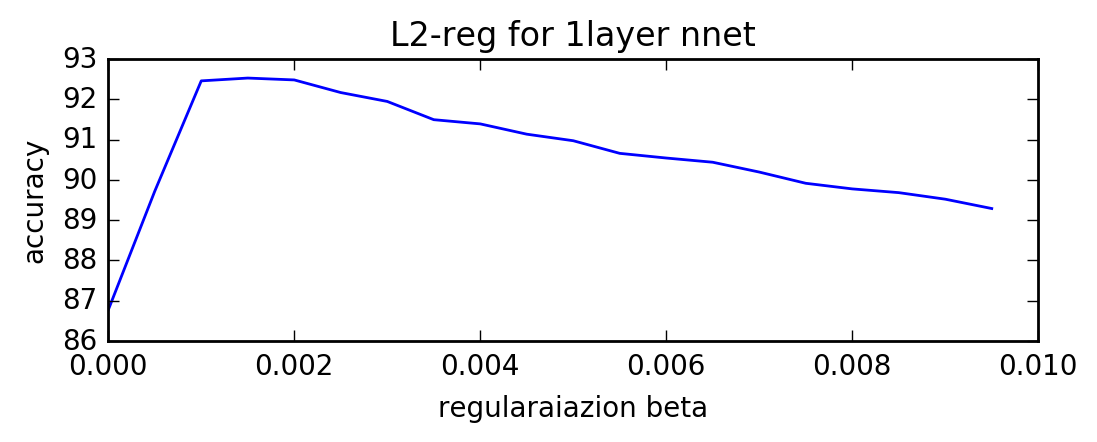

In [63]:
x = sorted([key for key in accuracy_obs.keys()])
plt.figure(1)
plt.subplot(211)
plt.plot(x, [accuracy_obs[x_] for x_ in x])
plt.title("L2-reg for 1layer nnet")
plt.xlabel("regularaiazion beta")
plt.ylabel("accuracy");

In [80]:
print("Best regularization parameter: {0:.4f}".format(
        [key for key, value in accuracy_obs.iteritems() if value == max(accuracy_obs.values())][0]))

Best regularization parameter: 0.0015


# Problem 2

Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

In [64]:
BATCH_SIZE = 128
HIDDEN_NODES = 1024

graph = tf.Graph()
def calculate_layer1(prev_layer, weights, biases):
    return tf.nn.relu(tf.matmul(prev_layer, weights) + biases)

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(BATCH_SIZE, IMAGE_SIZE**2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights0 = tf.Variable(tf.truncated_normal([IMAGE_SIZE **2, HIDDEN_NODES]))
    biases0 = tf.Variable(tf.zeros([HIDDEN_NODES]))
    weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS]))
    biases = tf.Variable(tf.zeros([NUM_LABELS]))
    
    tf_train_layer1 = calculate_layer1(tf_train_dataset, weights0, biases0) 
    logits = tf.matmul(tf_train_layer1, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    tf_valid_layer1 = calculate_layer1(tf_valid_dataset, weights0, biases0) 
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_layer1, weights) + biases)
    tf_test_layer1 = calculate_layer1(tf_test_dataset, weights0, biases0)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_layer1, weights) + biases)

num_steps = 100

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 349.798889
Minibatch accuracy: 7.0%
Validation accuracy: 32.9%
Minibatch loss at step 50: 55.463249
Minibatch accuracy: 68.8%
Validation accuracy: 73.2%
Test accuracy: 82.2%


# Problem 3

Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

In [17]:
BATCH_SIZE = 128
HIDDEN_NODES = 1024
KEEP_PROB = .4

graph = tf.Graph()
def calculate_layer1(prev_layer, weights, biases):
    return tf.nn.relu(tf.matmul(prev_layer, weights) + biases)

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(BATCH_SIZE, IMAGE_SIZE**2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights0 = tf.Variable(tf.truncated_normal([IMAGE_SIZE **2, HIDDEN_NODES]))
    biases0 = tf.Variable(tf.zeros([HIDDEN_NODES]))
    weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS]))
    biases = tf.Variable(tf.zeros([NUM_LABELS]))
    
    tf_train_layer1 = calculate_layer1(tf_train_dataset, weights0, biases0)
    dropout1 = tf.nn.dropout(tf_train_layer1, KEEP_PROB)
    logits = tf.matmul(dropout1, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    tf_valid_layer1 = calculate_layer1(tf_valid_dataset, weights0, biases0) 
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_layer1, weights) + biases)
    tf_test_layer1 = calculate_layer1(tf_test_dataset, weights0, biases0)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_layer1, weights) + biases)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 589.440186
Minibatch accuracy: 7.8%
Validation accuracy: 23.8%
Minibatch loss at step 500: 40.427826
Minibatch accuracy: 64.1%
Validation accuracy: 78.4%
Minibatch loss at step 1000: 20.421654
Minibatch accuracy: 69.5%
Validation accuracy: 76.5%
Minibatch loss at step 1500: 28.651527
Minibatch accuracy: 71.1%
Validation accuracy: 76.9%
Minibatch loss at step 2000: 17.213072
Minibatch accuracy: 65.6%
Validation accuracy: 75.2%
Minibatch loss at step 2500: 6.436152
Minibatch accuracy: 69.5%
Validation accuracy: 75.1%
Minibatch loss at step 3000: 14.252106
Minibatch accuracy: 72.7%
Validation accuracy: 74.3%
Test accuracy: 81.5%


# Problem 4

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.
One avenue you can explore is to add multiple layers.

In [31]:
BATCH_SIZE = 128
HIDDEN_NODES1 = 1024
HIDDEN_NODES2 = 512
KEEP_PROB = .5

graph = tf.Graph()
def calculate_layer(prev_layer, weights, biases):
    return tf.nn.relu(tf.matmul(prev_layer, weights) + biases)

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(BATCH_SIZE, IMAGE_SIZE**2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.constant(BETA)
    
    
    weights0 = tf.Variable(tf.truncated_normal([IMAGE_SIZE **2, HIDDEN_NODES1],
                                              stddev = np.sqrt(2./IMAGE_SIZE ** 2)))
    biases0 = tf.Variable(tf.zeros([HIDDEN_NODES1]))
    weights1 = tf.Variable(tf.truncated_normal([HIDDEN_NODES1, HIDDEN_NODES2],
                                               stddev = np.sqrt(2./HIDDEN_NODES1)))
    biases1 = tf.Variable(tf.zeros([HIDDEN_NODES2]))
    weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES2, NUM_LABELS],
                                              stddev = np.sqrt(2./HIDDEN_NODES2)))
    biases = tf.Variable(tf.zeros([NUM_LABELS]))
    
    tf_train_layer1 = calculate_layer(tf_train_dataset, weights0, biases0)
    #dropout1 = tf.nn.dropout(tf_train_layer1, KEEP_PROB)
    tf_train_layer2 = calculate_layer(tf_train_layer1, weights1, biases1)
    #dropout2 = tf.nn.dropout(tf_train_layer2, KEEP_PROB)
    logits = tf.matmul(tf_train_layer2, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        tf_beta * (tf.nn.l2_loss(weights0)+tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights))
  
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    tf_valid_layer1 = calculate_layer1(tf_valid_dataset, weights0, biases0) 
    tf_valid_layer2 = calculate_layer1(tf_valid_layer1, weights1, biases1) 
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_layer2, weights) + biases)
    tf_test_layer1 = calculate_layer1(tf_test_dataset, weights0, biases0)
    tf_test_layer2 = calculate_layer1(tf_test_layer1, weights1, biases1) 
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_layer2, weights) + biases)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Test accuracy: 93.0%


In [37]:
BATCH_SIZE = 128
HIDDEN_NODES1 = 1024
HIDDEN_NODES2 = 512
KEEP_PROB = .5

graph = tf.Graph()
def calculate_layer(prev_layer, weights, biases):
    return tf.nn.relu(tf.matmul(prev_layer, weights) + biases)

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(BATCH_SIZE, IMAGE_SIZE**2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.constant(BETA)
    global_step = tf.Variable(0)
    
    
    weights0 = tf.Variable(tf.truncated_normal([IMAGE_SIZE **2, HIDDEN_NODES1],
                                              stddev = np.sqrt(2./IMAGE_SIZE ** 2)))
    biases0 = tf.Variable(tf.zeros([HIDDEN_NODES1]))
    weights1 = tf.Variable(tf.truncated_normal([HIDDEN_NODES1, HIDDEN_NODES2],
                                               stddev = np.sqrt(2./HIDDEN_NODES1)))
    biases1 = tf.Variable(tf.zeros([HIDDEN_NODES2]))
    weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES2, NUM_LABELS],
                                              stddev = np.sqrt(2./HIDDEN_NODES2)))
    biases = tf.Variable(tf.zeros([NUM_LABELS]))
    
    tf_train_layer1 = calculate_layer(tf_train_dataset, weights0, biases0)
    #dropout1 = tf.nn.dropout(tf_train_layer1, KEEP_PROB)
    tf_train_layer2 = calculate_layer(tf_train_layer1, weights1, biases1)
    #dropout2 = tf.nn.dropout(tf_train_layer2, KEEP_PROB)
    logits = tf.matmul(tf_train_layer2, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        tf_beta * (tf.nn.l2_loss(weights0)+tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights))
    
    learning_rate = tf.train.exponential_decay(0.5, step, 500, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    tf_valid_layer1 = calculate_layer1(tf_valid_dataset, weights0, biases0) 
    tf_valid_layer2 = calculate_layer1(tf_valid_layer1, weights1, biases1) 
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_layer2, weights) + biases)
    tf_test_layer1 = calculate_layer1(tf_test_dataset, weights0, biases0)
    tf_test_layer2 = calculate_layer1(tf_test_layer1, weights1, biases1) 
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_layer2, weights) + biases)

num_steps = 6001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Test accuracy: 93.5%


In [38]:
BATCH_SIZE = 128
HIDDEN_NODES1 = 1024
HIDDEN_NODES2 = 512
KEEP_PROB = .5

graph = tf.Graph()
def calculate_layer(prev_layer, weights, biases):
    return tf.nn.relu(tf.matmul(prev_layer, weights) + biases)

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(BATCH_SIZE, IMAGE_SIZE**2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.constant(BETA)
    global_step = tf.Variable(0)
    
    
    weights0 = tf.Variable(tf.truncated_normal([IMAGE_SIZE **2, HIDDEN_NODES1],
                                              stddev = np.sqrt(2./IMAGE_SIZE ** 2)))
    biases0 = tf.Variable(tf.zeros([HIDDEN_NODES1]))
    weights1 = tf.Variable(tf.truncated_normal([HIDDEN_NODES1, HIDDEN_NODES2],
                                               stddev = np.sqrt(2./HIDDEN_NODES1)))
    biases1 = tf.Variable(tf.zeros([HIDDEN_NODES2]))
    weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES2, NUM_LABELS],
                                              stddev = np.sqrt(2./HIDDEN_NODES2)))
    biases = tf.Variable(tf.zeros([NUM_LABELS]))
    
    tf_train_layer1 = calculate_layer(tf_train_dataset, weights0, biases0)
    #dropout1 = tf.nn.dropout(tf_train_layer1, KEEP_PROB)
    tf_train_layer2 = calculate_layer(tf_train_layer1, weights1, biases1)
    #dropout2 = tf.nn.dropout(tf_train_layer2, KEEP_PROB)
    logits = tf.matmul(tf_train_layer2, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        tf_beta * (tf.nn.l2_loss(weights0)+tf.nn.l2_loss(weights1)+tf.nn.l2_loss(weights))
    
    learning_rate = tf.train.exponential_decay(0.5, step, 500, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    tf_valid_layer1 = calculate_layer1(tf_valid_dataset, weights0, biases0) 
    tf_valid_layer2 = calculate_layer1(tf_valid_layer1, weights1, biases1) 
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_layer2, weights) + biases)
    tf_test_layer1 = calculate_layer1(tf_test_dataset, weights0, biases0)
    tf_test_layer2 = calculate_layer1(tf_test_layer1, weights1, biases1) 
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_layer2, weights) + biases)

num_steps = 12001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Test accuracy: 93.7%
